In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [35]:
df = sns.load_dataset("titanic")


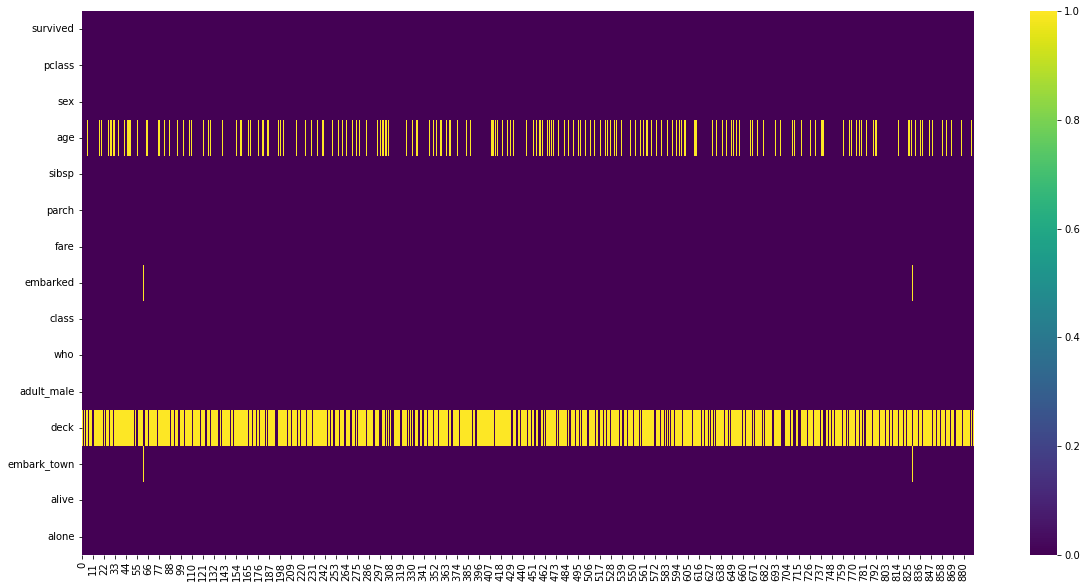

In [36]:
# White lines are nan values
nan_values_transpose = df.isna().transpose().copy()
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(nan_values_transpose, ax = ax, cmap = "viridis")
plt.show()



In [37]:
df.drop(["deck"], axis = 1, inplace = True)

# drop useless columns 
df.drop(["who","class","adult_male","embarked","alive","alone"], axis = 1, inplace = True)


In [38]:
df["sex"] = np.where(df.sex == "female", 1, 0)


In [39]:
df.corr()["age"].sort_values()


/tmp/ipykernel_89195/1531610455.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



pclass     -0.369226
sibsp      -0.308247
parch      -0.189119
sex        -0.093254
survived   -0.077221
fare        0.096067
age         1.000000
Name: age, dtype: float64

In [40]:
pclass_age = df.groupby(["pclass"])["age"].agg(["mean", "median","min","max","count"])
pclass_age


,mean,median,min,max,count
pclass,,,,,
1,38.233441,37.0,0.92,80.0,186
2,29.877630,29.0,0.67,70.0,173
3,25.140620,24.0,0.42,74.0,355


In [41]:
sibsp_age = df.groupby(["sibsp"])["age"].agg(["mean", "median","min","max","count"])
sibsp_age


,mean,median,min,max,count
sibsp,,,,,
0,31.397558,29.0,0.42,80.0,471
1,30.089727,30.0,0.67,70.0,183
2,22.620000,23.0,0.75,53.0,25
3,13.916667,9.5,2.00,33.0,12
4,7.055556,6.5,1.00,17.0,18
5,10.200000,11.0,1.00,16.0,5
8,NaN,NaN,NaN,NaN,0


In [42]:
pclass_sibsp_age = df.groupby(["pclass","sibsp"])["age"].agg(["mean", "median","min","max","count"])
pclass_sibsp_age


mean  median    min   max  count
pclass sibsp                                       
1      0      39.181416    37.0   4.00  80.0    113
       1      37.414154    38.0   0.92  70.0     65
       2      37.200000    44.0  18.00  53.0      5
       3      22.000000    23.0  19.00  24.0      3
2      0      31.934220    30.0   0.83  70.0    109
       1      27.363636    29.0   0.67  60.0     55
       2      19.125000    23.5   1.00  32.0      8
       3      30.000000    30.0  30.00  30.0      1
3      0      27.630201    26.0   0.42  74.0    249
       1      24.912698    25.0   1.00  48.0     63
       2      18.875000    19.5   0.75  41.0     12
       3       8.875000     6.0   2.00  33.0      8
       4       7.055556     6.5   1.00  17.0     18
       5      10.200000    11.0   1.00  16.0      5
       8            NaN     NaN    NaN   NaN      0

In [43]:
df.age.mean()


29.69911764705882

In [44]:
def fill_nan_age(x):
    if (x == 0):
        return 32
    elif (x == 1):
        return 30
    elif (x == 2):
        return 23
    elif (x == 3):
        return 14
    elif (x == 4):
        return 7
    elif (x == 5):
        return 10
    else:
        return 30


In [45]:
df["age"] = df.apply(lambda x : fill_nan_age(x.sibsp) if pd.isnull(x.age) else x.age, axis = 1 )


In [46]:
df = df.dropna().reset_index(drop = True)


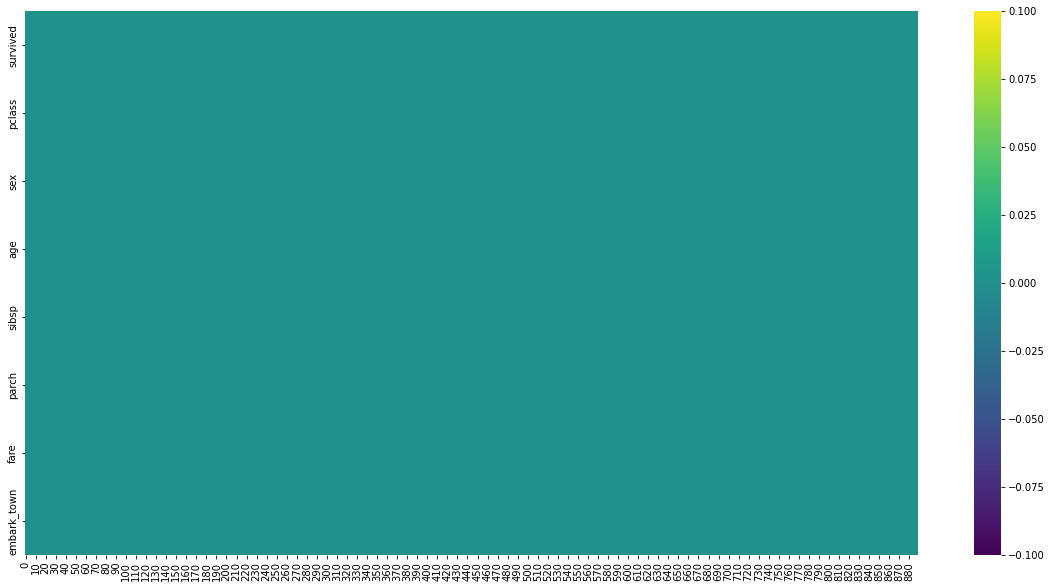

In [47]:
nan_values_transpose_final = df.isna().transpose().copy()
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(nan_values_transpose_final, ax = ax, cmap = "viridis")
plt.show()


In [48]:
df = pd.get_dummies(df, columns = ["embark_town"], drop_first = True)


In [49]:
df.corr()["survived"].sort_values(ascending = False)


survived                   1.000000
sex                        0.541585
fare                       0.255290
parch                      0.083151
embark_town_Queenstown     0.004536
sibsp                     -0.034040
age                       -0.077954
embark_town_Southampton   -0.151777
pclass                    -0.335549
Name: survived, dtype: float64

In [50]:
scatter = px.scatter(df, x = "fare", y = "survived", color = "sex", size = "pclass")
scatter.show()

In [51]:
# cut the target column
y = df["survived"]
X = df.drop(["survived"], axis = 1)


In [52]:
# split data
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 13)

In [53]:
# Normalization

age_scaler = MinMaxScaler()
fare_scaler = MinMaxScaler()

age_scaler.fit(np.reshape(X_train.age.values,(-1,1)))
X_train["age"] = np.squeeze(age_scaler.transform(np.reshape(X_train.age.values,(-1,1))))
X_test["age"] = np.squeeze(age_scaler.transform(np.reshape(X_test.age.values,(-1,1))))


fare_scaler.fit(np.reshape(X_train.fare.values,(-1,1)))
X_train["fare"] = np.squeeze(fare_scaler.transform(np.reshape(X_train.fare.values,(-1,1))))
X_test["fare"] = np.squeeze(fare_scaler.transform(np.reshape(X_test.fare.values,(-1,1))))

In [54]:
# create a list to compare result of each model at the end
models_result = []

In [55]:
# LogisticRegression model
lgreg = LogisticRegression(max_iter = 200)
lgreg.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [56]:
# RandomForest model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [57]:
# SVC model
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [58]:
# NN model 
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(100, input_shape =(X_train.shape[1],), activation = "relu" ))
    model.add(tf.keras.layers.Dense(20, activation = "relu" ))
    model.add(tf.keras.layers.Dense(1, activation = "sigmoid" ))
    model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"] )
    return model

In [59]:
# build model
model_nn = build_model()

In [60]:
# summary of NN model
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               900       
                                                                 
 dense_4 (Dense)             (None, 20)                2020      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,941
Trainable params: 2,941
Non-trainable params: 0
_________________________________________________________________


In [61]:
# fit NN model
model_nn.fit(X_train,y_train, epochs = 5000, batch_size = 32)

Epoch 1/5000
23/23 [==============================] - 1s 3ms/step - loss: 0.6420 - accuracy: 0.6160
Epoch 2/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.5752 - accuracy: 0.6864
Epoch 3/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.5271 - accuracy: 0.7707
Epoch 4/5000
23/23 [==============================] - 0s 2ms/step - loss: 0.4858 - accuracy: 0.7918
Epoch 5/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.4665 - accuracy: 0.7890
Epoch 6/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.4551 - accuracy: 0.7947
Epoch 7/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.4511 - accuracy: 0.7947
Epoch 8/5000
23/23 [==============================] - 0s 3ms/step - loss: 0.4460 - accuracy: 0.7961
Epoch 9/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.4419 - accuracy: 0.8003
Epoch 10/5000
23/23 [==============================] - 0s 4ms/step - loss: 0.4461 - accuracy: 0.7947

In [62]:
# estimate score of each model by using different random states. At the end mean is important.
scores_nn = []
score_lgreg = []
score_rfc = []
score_svc = []

for i in range(10):
    # spliting
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = i)
    
    # NN
    prediction_nn = model_nn.predict(X_test)
    prediction_nn_final = np.where(prediction_nn > 0.5, 1,0)
    score_nn_i = f1_score(y_test,prediction_nn_final)
    scores_nn.append(score_nn_i)

    # LogisticRegression
    prediction_lgreg = lgreg.predict(X_test)
    score_lgreg_i = f1_score(y_test,prediction_lgreg)
    score_lgreg.append(score_lgreg_i)

    # RandomForest
    prediction_rfc = rfc.predict(X_test)
    score_rfc_i = f1_score(y_test,prediction_rfc)
    score_rfc.append(score_rfc_i)

    # SVC
    prediction_svc = svc.predict(X_test)
    score_svc_i = f1_score(y_test,prediction_svc)
    score_svc.append(score_svc_i)

models_result.append(["NN", np.mean(scores_nn)])
models_result.append(["LogisticRegression", np.mean(score_lgreg)])
models_result.append(["RandomForest", np.mean(score_rfc)])
models_result.append(["SVC", np.mean(score_svc)])


6/6 [==============================] - 0s 2ms/step


In [63]:
# create dataframe based on models and scores 
compare_df = pd.DataFrame(models_result, columns = ["model","score"])

In [64]:
# convert scores to percentage and then round them.
compare_df["score"] = (compare_df["score"] * 100).round(2)

In [65]:
# Based on f1-score (main measure for models) can see which model did best on titanic dataset
compare_df.sort_values(["score"], ascending = False)

,model,score
2,RandomForest,71.39
0,NN,56.23
1,LogisticRegression,22.59
3,SVC,0.00


In [66]:
# Author: amyrmahdy
# Date: 4 Dec 2022